In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [3]:
fake_news = pd.read_csv("./input_data/Fake.csv")
fake_news.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [4]:
true_news = pd.read_csv("./input_data/True.csv")
true_news.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


## 0: True news
## 1: Fake news

In [5]:
fake_news_df = pd.DataFrame()
fake_news_df['news'] = fake_news['title']
fake_news_df['label'] = 1

true_news_df = pd.DataFrame()
true_news_df['news'] = true_news['title']
true_news_df['label'] = 0
final_dataset = pd.concat([fake_news_df, true_news_df]).reset_index(drop=True)
final_dataset

,news,label
0,Donald Trump Sends Out Embarrassing New Year’...,1
1,Drunk Bragging Trump Staffer Started Russian ...,1
2,Sheriff David Clarke Becomes An Internet Joke...,1
3,Trump Is So Obsessed He Even Has Obama’s Name...,1
4,Pope Francis Just Called Out Donald Trump Dur...,1
...,...,...
44893,'Fully committed' NATO backs new U.S. approach...,0
44894,LexisNexis withdrew two products from Chinese ...,0
44895,Minsk cultural hub becomes haven from authorities,0
44896,Vatican upbeat on possibility of Pope Francis ...,0


In [6]:
final_dataset.shape

(44898, 2)

In [7]:
final_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   news    44898 non-null  object
 1   label   44898 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 701.7+ KB


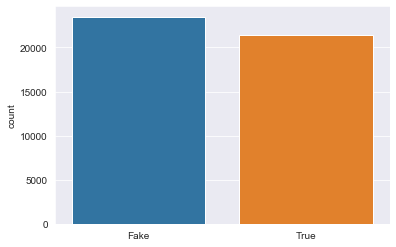

In [8]:
l = []
for i in final_dataset['label']:
    if(i == 0):
        l.append("True")
    else:
        l.append("Fake")
sns.set_style('darkgrid')
sns.countplot(l)

# Data Cleaning

In [9]:
import re
import string
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\srija\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [10]:
# News-Punctuation Cleaning
# Creating a copy 
clean_news = final_dataset.copy()
def review_cleaning(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

clean_news['news'] = clean_news['news'].apply(lambda x:review_cleaning(x))
clean_news

,news,label
0,donald trump sends out embarrassing new year’...,1
1,drunk bragging trump staffer started russian ...,1
2,sheriff david clarke becomes an internet joke...,1
3,trump is so obsessed he even has obama’s name...,1
4,pope francis just called out donald trump dur...,1
...,...,...
44893,fully committed nato backs new us approach on ...,0
44894,lexisnexis withdrew two products from chinese ...,0
44895,minsk cultural hub becomes haven from authorities,0
44896,vatican upbeat on possibility of pope francis ...,0


In [11]:
stop = stopwords.words('english')
clean_news['news'] = clean_news['news'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
clean_news.head()

,news,label
0,donald trump sends embarrassing new year’s eve...,1
1,drunk bragging trump staffer started russian c...,1
2,sheriff david clarke becomes internet joke thr...,1
3,trump obsessed even obama’s name coded website...,1
4,pope francis called donald trump christmas speech,1


In [12]:
news_features = clean_news.copy()
news_features = news_features[['news']].reset_index(drop=True)
news_features.head()

,news
0,donald trump sends embarrassing new year’s eve...
1,drunk bragging trump staffer started russian c...
2,sheriff david clarke becomes internet joke thr...
3,trump obsessed even obama’s name coded website...
4,pope francis called donald trump christmas speech


In [13]:
stop_words = set(stopwords.words("english"))
#Performing stemming on the review dataframe
ps = PorterStemmer()

#splitting and adding the stemmed words except stopwords
corpus = []
for i in range(0, len(news_features)):
    news = re.sub('[^a-zA-Z]', ' ', news_features['news'][i])
    news= news.lower()
    news = news.split()
    news = [ps.stem(word) for word in news if not word in stop_words]
    news = ' '.join(news)
    corpus.append(news)#Getting the target variable

'donald trump send embarrass new year eve messag disturb'

In [19]:
for words in corpus:
    print(words)
    print(one_hot(words, voc_size))
    break

donald trump send embarrass new year eve messag disturb
[3554, 5217, 1334, 6905, 9479, 4015, 9608, 2482, 6409]


In [15]:
y = clean_news['label']

In [16]:
#Setting up vocabulary size
voc_size=10000

#One hot encoding 
onehot_repr=[one_hot(words,voc_size)for words in corpus]
onehot_repr[0]

[3554, 5217, 1334, 6905, 9479, 4015, 9608, 2482, 6409]

In [14]:
#Setting sentence length
sent_length=1000

#Padding the sentences
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
embedded_docs

array([[   0,    0,    0, ..., 6472, 8637, 6163],
       [   0,    0,    0, ..., 5908, 8378, 9716],
       [   0,    0,    0, ..., 9357, 4434, 3889],
       ...,
       [   0,    0,    0, ..., 2459, 8418, 9921],
       [   0,    0,    0, ..., 5107, 9480, 4682],
       [   0,    0,    0, ..., 8725, 5908, 8694]])

# LSTM model

In [15]:
from tensorflow.keras import models
from tensorflow.keras import layers

In [16]:
embedding_vector_features=40

model = models.Sequential()
model.add(layers.Embedding(voc_size, embedding_vector_features, input_length=sent_length))
model.add(layers.Dropout(0.3))
model.add(layers.LSTM(100))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 40)          400000    
_________________________________________________________________
dropout (Dropout)            (None, 1000, 40)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               56400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
________________________________________________________

In [17]:
# Converting the X and y as array
X_final = np.array(embedded_docs)
y_final = np.array(y)

#Check shape of X and y final
X_final.shape,y_final.shape

((44898, 1000), (44898,))

In [18]:
from sklearn.model_selection import train_test_split

In [19]:
# Train test split of the X and y final
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.33, random_state=42)

In [20]:
model.fit(X_train, y_train, validation_data=(X_test,y_test), epochs=3, batch_size=32)

Train on 30081 samples, validate on 14817 samples
Epoch 1/3
30081/30081 [==============================] - 1636s 54ms/sample - loss: 0.4352 - acc: 0.8261 - val_loss: 0.1876 - val_acc: 0.9246
Epoch 2/3
30081/30081 [==============================] - 1712s 57ms/sample - loss: 0.1565 - acc: 0.9395 - val_loss: 0.1689 - val_acc: 0.9307
Epoch 3/3
30081/30081 [==============================] - 1723s 57ms/sample - loss: 0.2412 - acc: 0.9125 - val_loss: 0.3228 - val_acc: 0.8668


# Evaluation of model

In [21]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, plot_confusion_matrix

In [22]:
y_pred = model.predict_classes(X_test)

In [23]:
y_pred[:10].reshape(-1), y_test[:10]

(array([0, 0, 0, 1, 0, 1, 1, 1, 0, 0]),
 array([1, 0, 0, 1, 0, 1, 1, 1, 0, 0], dtype=int64))

In [24]:
cm = confusion_matrix(y_test, y_pred)
cm

array([[6657,  382],
       [1591, 6187]], dtype=int64)

In [25]:
# Creating classification report 
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.81      0.95      0.87      7039
           1       0.94      0.80      0.86      7778

    accuracy                           0.87     14817
   macro avg       0.87      0.87      0.87     14817
weighted avg       0.88      0.87      0.87     14817



In [26]:
#Checking for accuracy
accuracy_score(y_test, y_pred) * 100

86.68421407842342

In [27]:
model.save('fake_news_lstm.model')